# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:
```
!pip uninstall gym -y
!pip install gym
```

In [ ]:
# !pip install -U gym==0.25.2
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!pip install swig
!pip install gym[box2d]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics
import torch
import os

import warnings
warnings.filterwarnings('ignore')

In [4]:
def display_video(episode=0, video_width=600, video_dir= "/content/video"):

    video_path = os.path.join(video_dir, f"rl-video-episode-{episode}.mp4")
    video_file = open(video_path, "rb").read()
    decoded = b64encode(video_file).decode()
    video_url = f"data:video/mp4;base64,{decoded}"
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode=None, video_folder='/content/video'):
    # render mode: "human", "rgb_array", "ansi")
    env = gym.make(name, new_step_api=True, render_mode=render_mode)
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 50 == 0)
    env = RecordEpisodeStatistics(env)
    return env

def show_reward(total_rewards):
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

## **Dynamic programming**
we have just developed an MDP and computed the value function of the optimal policy using matrix inversion.

Dynamic programming is an optimization technique that was developed by Richard Bellman in 1950s.

policy evaluation is a iterative algorithm. It starts with arbitrary policy values and then iteratively update the values base on **Bellman expectation equation** until they converge. In each iteration value of a policy $\pi$, for state $S$ is updated as follow:

<br>

The Bellman expectation equations:
---

---
<br>

- **For $V_\pi(s)$:**

$$
    V_\pi(s) = \sum_{a} \pi(a|s) \sum_{s{'}} P(s{'}| s, a) \left[ R(s, a, s{'}) + \gamma V_\pi(s{'}) \right]
$$

- **For $Q_{\pi}(s, a)$**

$$
\begin{split}
    Q_\pi(s, a) & = \sum_{s{'}} P(s{'}| s, a) \left[ R(s, a, s{'}) + \gamma \sum_{a{'}} \pi(a{'} | s{'}) Q_\pi(s{'}, a{'}) \right] \\
    \text{as we know: } v_{\pi}(s) & = \sum_{a} \pi(a| s) Q_\pi(s, a) \text{ So: }\\
    Q_\pi(s, a) & = \sum_{s{'}} P(s{'}| s, a) \left[ R(s, a, s{'}) + \gamma v_{\pi}(s^{'}) \right] \\
\end{split}
$$

<br>

The Bellman Optimality equations:
---

---
<br>

- **For $V(s)$:**

$$
V_*(s) = \max_a \sum_{s{'}} P(s{'} | s, a) \left[ R(s, a, s{'}) + \gamma V^(s{'}) \right]
$$


- **For $Q_{\pi}(s, a)$**

$$
Q_*(s, a) = \sum_{s{'}} P(s{'} | s, a) \left[ R(s, a, s{'}) + \gamma \max_{a{'}} Q_*(s{'}, a{'}) \right]
$$

---
<br>

1. **Policy evaluation or prediction**: first we use *expectation* equations to evaluate a policy
2. **policy improvement**: then we use *optimality* equations to find an optimal policy that maximizes the state values and state-action values.



**Note**: In order to use this method the problem should have finite states and actions.

## **Performing Policy evalulation**

$$
\begin{split}
    \large (1) \hspace{5mm} V_{n+1}(s) & \leftarrow \sum_{a} \pi(a|s) \sum_{s{'}} P(s{'}| s, a) \left[ R(s, a, s{'}) + \gamma V_n(s{'}) \right] \\
    \text{Or} \\
    \large (2) \hspace{5mm} V_{n+1}(s) & \leftarrow \sum_{a}{\pi(s, a)\left[R(s,a) +
    \gamma\sum_{s^{'}}{T(s,a,s^{'})V_n(s{'})}\right]}
\end{split}
$$


>Since we want to iterate over and over again, $V(s)$ subscript changed from $\pi$ to $n$ and $n+1$. We initialize the value function $V$ to zeros for all states at the beginning.

If $n \rightarrow \infty$ then $V_n(s)$ will converge to $V_{\pi}(s)$

**Note**: Here is the implementation of the second one.

In [22]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    """
    Evaluates the value function for a given policy using the Bellman expectation equation.

    Parameters:
        policy (torch.Tensor): A matrix of shape (n_state, n_action), where each entry represents the probability
                               of taking an action in a given state under the policy.
        trans_matrix (torch.Tensor): A matrix of shape (n_state, n_action, n_state), representing the transition
                                     probabilities. Entry trans_matrix[s, a, s'] is the probability of transitioning
                                     from state s to state s' by taking action a.
        rewards (torch.Tensor): A vector of shape (n_state,) containing the immediate rewards for each state.
        gamma (float): The discount factor, which determines the importance of future rewards (0 <= gamma < 1).
        threshold (float): A small positive number to determine the stopping condition for convergence.

    Returns:
        V (torch.Tensor): The estimated state-value function for the given policy.
        v_history (list): A list containing the history of state-value functions over iterations.
    """
    # Number of states
    n_state = policy.shape[0]

    # Initialize the value function V to zeros for all states
    V = torch.zeros(n_state)

    # Keep track of the history of V for analysis
    v_history = [V]

    # Start the policy evaluation loop
    while True:
        # Temporary value function to compute updated values
        v_temp = torch.zeros(n_state)

        # Iterate over each state
        for state, actions in enumerate(policy):
            # Iterate over each action in the given state
            for action, action_prob in enumerate(actions):
                # Compute the expected value of transitioning to all possible next states
                sigma = torch.dot(trans_matrix[state, action], V)  # Sum P(s' | s, a) * V(s')
                # Update the temporary value function with the expected reward and discounted value
                # V(s) = Σ_a 𝜋(𝑠,𝑎)[𝑅(𝑠,𝑎) + γ * ∑_𝑠′𝑇(𝑠,𝑎,𝑠′)𝑉(𝑠′)]
                v_temp[state] += action_prob * (rewards[state] + gamma * sigma)

        # Compute the maximum change (delta) between the old and updated value functions
        delta = torch.max(torch.abs(V - v_temp))

        # Update the value function with the newly computed values
        V = v_temp.clone()

        # Append the current value function to the history for analysis
        v_history.append(V)

        # Check if the change (delta) is below the convergence threshold
        if delta <= threshold:
            break

    # Return the final value function and the history of updates
    return V, v_history

In [23]:
# Define the transition probability matrix (T)
T = torch.tensor(
    [[[0.8, 0.1, 0.1],  # From state 0, action 0 leads to state 0 with 80% probability, state 1 with 10%, state 2 with 10%.
      [0.1, 0.6, 0.3]],  # From state 0, action 1 leads to state 0 with 10%, state 1 with 60%, state 2 with 30%.
     [[0.7, 0.2, 0.1],  # From state 1, action 0 leads to state 0 with 70%, state 1 with 20%, state 2 with 10%.
      [0.1, 0.8, 0.1]],  # From state 1, action 1 leads to state 0 with 10%, state 1 with 80%, state 2 with 10%.
     [[0.6, 0.2, 0.2],  # From state 2, action 0 leads to state 0 with 60%, state 1 with 20%, state 2 with 20%.
      [0.1, 0.4, 0.5]]]  # From state 2, action 1 leads to state 0 with 10%, state 1 with 40%, state 2 with 50%.
)

R = torch.tensor([1., 0., -1.])  # State 0 gives a reward of 1, state 1 gives 0, and state 2 gives -1.

gamma = 0.5  # Future rewards are discounted by a factor of 0.5.

policy_optimal = torch.tensor(
    [[1., 0.],  # In state 0, the policy always chooses action 0 (probability 1.0 for action 0, 0.0 for action 1).
     [1., 0.],  # In state 1, the policy always chooses action 0.
     [1., 0.]]  # In state 2, the policy always chooses action 0.
)

threshhold = 0.0001  # Stop iterating when the maximum change in value estimates is below this threshold.

# Perform policy evaluation to compute the value function under the optimal policy
V, _ = policy_evaluation(policy_optimal, T, R, gamma, threshhold)

print(f"The value function under the optimal policy is: \n{V.numpy()}")

The value function under the optimal policy is: 
[ 1.6785905   0.6259589  -0.48207426]


In [7]:
policy_optimal = torch.tensor(
    [[.5, .5],
     [.5, .5],
     [.5, .5]]
)

V, v_history = policy_evaluation(policy_optimal, T, R, gamma, threshhold)
print(f"the value function under the optimal policy is: \n{V.numpy()}")

the value function under the optimal policy is: 
[ 1.2347662   0.26914817 -0.90129805]


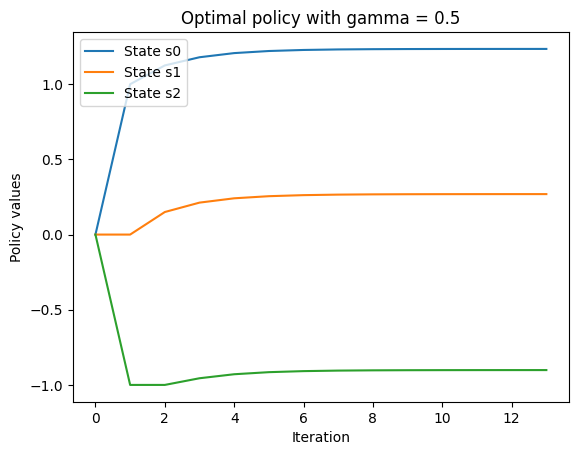

In [25]:
# Plot the value function for each state over iterations
s0, = plt.plot([v[0] for v in v_history])  # Extract and plot the value of state s0 over all iterations
s1, = plt.plot([v[1] for v in v_history])  # Extract and plot the value of state s1 over all iterations
s2, = plt.plot([v[2] for v in v_history])  # Extract and plot the value of state s2 over all iterations

plt.title(f"Optimal policy with gamma = {gamma}")
plt.xlabel("Iteration")
plt.ylabel("Policy values")
plt.legend([s0, s1, s2], ["State s0", "State s1", "State s2"], loc="upper left")
plt.show()

## **Value iteration algorithm**

An MDP is considered solved if it's optinal policy is found. we will figure out the optimal policy for the Frozen Lake environment using **value iteration**

The behind this algorithm is quite similar to that of policy evaluation, It is also an iterative algorithm. It starts with arbitrary policy value and the iteratively updates the values base on **Bellman optimality equation**. So in each iteration instead of taking the expectation(average) of values across all actions, it pick the action that achieve the maximal policy values:

<br>

---

$$
\large\textit{Bellman optimality equations:}\\
$$

$$
\begin{split}
    V_{*}(s) & = max_{a}\left[R(s,a) + \gamma\sum_{s^{'}}{T(s,a,s^{'})V_{*}(s^{'})}\right] \\
    \text{or} \\
    \\
    V_{*}(s) & = max_{a}\sum_{s^{'}}{T(s,a,s^{'})} \left[R(s,a, s^{'}) + \gamma V_{*}(s^{'})\right]
\end{split}
$$

---

<br>

Once the optimal values are computed, we can easily obtain the obtimal policy acccordingly:

$$
\pi_{*}(s) := argmax_{a}\sum_{s^{'}}{T(s,a,s^{'})}
\left[R(s,a, s^{'}) + \gamma V_{*}(s^{'})\right]
$$

<br>

- **Gym Environment**

```
env.env.P[s][a] --> Transition_matrix_Prob, next_state, reward, info
```
we going to use above function for value iteration algorithm

## **Key Difference Between Policy Evaluation and Value Iteration**

1. **Policy Evaluation:**
- **Goal**: Compute the value function $V_\pi(s)$ for a fixed policy $\pi$, which specifies the probability of taking each action in every state.
- **Update Rule**:

$$
    V_\pi(s) = \sum_{a} \pi(a|s) \sum_{s{'}} P(s{'}|s, a) \left[ R(s, a, s{'}) + \gamma V_\pi(s{'}) \right]
$$
> *Input*: A fixed policy $\pi$. <br> *Output*: The value function $V_\pi(s)$ for that policy.

<br>

2. **Value Iteration:**
- **Goal**: Find the optimal value function $V(s)$ and derive the optimal policy $\pi$.

- **Update Rule**:  It iteratively computes the optimal value function by taking the maximum over all possible actions.

$$
V_*(s) = \max_a \sum_{s{'}} P(s{'}|s, a) \left[ R(s, a, s{'}) + \gamma V(s{'}) \right]
$$

> *Input*: The environment’s dynamics (transition probabilities and rewards). <br> *Output*: The optimal value function $V_*(s)$.

In [26]:
def value_iteration(env, gamma, threshold):
    """
    Performs value iteration to compute the optimal value function.

    Parameters:
        env: The environment object (assumed to follow OpenAI Gym's structure).
        gamma: The discount factor (0 <= gamma < 1).
        threshold: The convergence threshold for stopping the algorithm.

    Returns:
        V: The optimal value function for the environment.
    """
    n_state = env.observation_space.n # Number of states in the environment
    n_action = env.action_space.n # Number of actions in the environment

    # Initialize the value function to zero for all states
    V = torch.zeros(n_state)

    # Start the value iteration loop
    while True:
        # Temporary value function to store updated values
        v_temp = torch.empty(n_state)

        # Iterate over each state in the environment
        for state in range(n_state):
            # Compute the value for each action in the current state
            v_action = torch.zeros(n_action)
            for action in range(n_action):
                # Iterate over all possible transitions for the (state, action) pair
                for T_prob, s_prime, R, _ in env.env.P[state][action]:
                    # Add the contribution of each transition to the action value
                    v_action[action] += T_prob * (R + gamma * V[s_prime].item())

            # Take the maximum action value as the new value for the current state
            v_temp[state] = torch.max(v_action)

        # Compute the maximum change in value across all states (convergence check)
        delta = torch.max(torch.abs(V - v_temp))

        # Update the value function
        V = v_temp.clone()

        # Stop iterating if the maximum change is below the threshold
        if delta <= threshold:
            break

    # Return the optimal value function
    return V

## **Policy imporovement**

In the previous section, after starting with a random policy, we getting $V(s)$ for a given policy. Instead of followinga random policy $\pi(a|s)$, now we look at the value of taking $|A|$ number of actions individually. These are the action value ($q(s,a )$) of each action we can take in our environment:

$$
    \large q(s, a) = \sum_{s^{'}, a}p(s^{'},r|s, a) \left[ r + \gamma v_{\pi}(s^{'}) \right]
$$

If any of the $q(s, a)$ is greater than the current state value $v_π(s)$, it means that current policy $π(a| s)$ is not taking the optimal action. So Taking the q-value with max action (**Greedy step**) vlaue and defining this to be the policy in state $S$ will give a higher state value compared to the current policy $π(a| s)$:

$$
    \large \pi^{'}(a|s) = \underset{a}{\textit{argmax}} \ q(s, a)
$$

In [ ]:
def policy_improvment(env, optimal_value, gamma):
    """
    Performs policy improvement based on a given optimal value function.

    Parameters:
        env: The environment object (assumed to follow OpenAI Gym's structure).
        optimal_value (torch.Tensor): The optimal value function computed previously.
        gamma (float): The discount factor (0 <= gamma < 1).

    Returns:
        policy (torch.Tensor): The improved policy, where each entry represents the optimal action for a given state.
    """
    n_state = env.observation_space.n # Number of states in the environment
    n_action = env.action_space.n # Number of actions in the environment

    # Initialize the policy as a tensor of zeros (one action per state)
    policy = torch.zeros(n_state)

    # Iterate over each state in the environment
    for state in range(n_state):
        # Initialize a tensor to store the value of each action in the current state
        v_action = torch.zeros(n_action)

        # Iterate over all possible actions for the current state
        for action in range(n_action):
            # Iterate over all possible transitions for the (state, action) pair
            for T_prob, s_prime, R, _ in env.env.P[state][action]:
                # Compute the action value using the Bellman optimality equation:
                # Q(s, a) = Σ_s' P(s'|s, a) * [R(s, a, s') + γ * V(s')]
                v_action[action] += T_prob * (R + gamma * optimal_value[s_prime].item())

        # Choose the action with the highest value (greedy policy)
        policy[state] = torch.argmax(v_action)

    # Return the improved policy
    return policy

In [27]:
gamma = 0.99
threshhold = 0.0001
v_optimal = value_iteration(env, gamma, threshhold)
optimal_policy = policy_improvment(env, v_optimal, gamma).long()

In [28]:
def run_episode(env, policy):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = policy[state].item()
        state, reward, done, _ =  env.step(action)
        total_reward += reward

    return total_reward

In [29]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

## **Frozen Lake Environment**
<center><img align="right" width="200" src="https://www.gymlibrary.dev/_images/frozen_lake.gif">

<br>

|                   |            |
|-------------------|--------------|
| action Space      | Discrete(4) |
| Observation Space | Discrete(16) |
| Import            | `gym.make("FrozenLake-v1")` |


In [30]:
env = create_env("FrozenLake-v1")
n_episode = 500
total_rewards = []
for episode in range(n_episode):
    R = run_episode(env, optimal_policy)
    total_rewards.append(R)

    if episode % 50 == 0 and episode > 0:
        avg_tot_reward = sum(total_rewards) / episode
        print(f"Average total reward over {episode} episodes: {avg_tot_reward:.2f}")


Average total reward over 50 episodes: 0.76
Average total reward over 100 episodes: 0.74
Average total reward over 150 episodes: 0.73
Average total reward over 200 episodes: 0.72
Average total reward over 250 episodes: 0.75
Average total reward over 300 episodes: 0.77
Average total reward over 350 episodes: 0.76
Average total reward over 400 episodes: 0.76
Average total reward over 450 episodes: 0.76


In [17]:
display_video(450)

## **Policy iteration algorithm**
this algorithm can be divided into two components:
1. policy evaluation
2. policy improvment

It starts with an arbitrary policy, And each iteration, It first computes the policy values given the latest policy, Based on the $\normalsize\textit{Bellman expectation equation}$; It then extract an improved policy out the resulting policy values, Based on the $\normalsize\textit{Bellman optimality equation}$. It iteratively evaluates the policy and generates an improved version until the policy doesn't change any more.

<br>

$$
\large \textit{Bellman expectation equation:}\\
V(s) = \sum_{a}{\pi(s, a)\left[R(s,a) +
\gamma\sum_{s^{'}}{T(s,a,s^{'})V(s^{'})}\right]}
$$

<br>

$$
\large\textit{Bellman optimality equation}\\
\pi_{*}(s) := argmax_{a}\sum_{s^{'}}{T(s,a,s^{'})}
\left[R(s,a, s^{'}) + \gamma V_{*}(s^{'})\right]
$$

<br>
<br>

now we implement Policy evaluation and Policy imporovement multiple time:

<br>

$$
    \large \pi_0 \xrightarrow{evaluation} v_{\pi_0} \xrightarrow{improve} \pi_1 \xrightarrow{evaluation} v_{\pi_1} \xrightarrow{improve} \pi_2 ...  \pi_* \xrightarrow{evaluation} v_{*}
$$

In [35]:
def policy_evaluation(env, policy, gamma, threshhold):
    n_state = env.observation_space.n
    V = torch.zeros(n_state)
    while True:
        v_temp = torch.zeros(n_state)
        for state in range(n_state):
            action = policy[state].item()
            for T_prob, s_prime, R, _ in env.env.P[state][action]:
                v_temp[state] += T_prob * (R + gamma * V[s_prime].item())

        delta = torch.max(torch.abs(V - v_temp))
        V = v_temp.clone()
        if delta <= threshhold:
            break
    return V


def policy_improvment(env, optimal_value, gamma):
    n_state = env.observation_space.n
    n_action = env.action_space.n
    policy = torch.zeros(n_state)
    for state in range(n_state):
        v_action = torch.zeros(n_action)
        for action in range(n_action):
            for T_prob, s_prime, R, _ in env.env.P[state][action]:
                v_action[action] += T_prob * (R + gamma * optimal_value[s_prime].item())

        policy[state] = torch.argmax(v_action)

    return policy

In [36]:
def policy_iteration(env, gamma, threshhold):
    """
    Performs policy iteration to compute the optimal policy and value function.

    Parameters:
        env: The environment object (assumed to follow OpenAI Gym's structure).
        gamma (float): The discount factor (0 <= gamma < 1).
        threshhold (float): The convergence threshold for stopping the policy evaluation step.

    Returns:
        V (torch.Tensor): The optimal value function for the environment.
        improved_policy (torch.Tensor): The optimal policy derived through policy iteration.
    """
    n_state = env.observation_space.n # Number of states in the environment
    n_action = env.action_space.n # Number of actions in the environment

    # Initialize a random policy with shape (n_state,)
    # Each state is assigned a random action initially
    policy = torch.randint(high=n_action, size=(n_state,)).float()

    # Start the policy iteration loop
    while True:
        # Evaluate the current policy to compute the value function
        V = policy_evaluation(env, policy, gamma, threshhold)

        # Improve the policy based on the computed value function
        improved_policy = policy_improvment(env, V, gamma)

        # Check if the policy has converged (no changes in policy)
        if torch.equal(improved_policy, policy):
            # Return the optimal value function and policy
            return V, improved_policy

        # Update the policy for the next iteration
        policy = improved_policy

In [37]:
env = create_env("FrozenLake-v1")
gamma = 0.99
threshhold = 0.0001
v_optimal, policy_improved = policy_iteration(env, gamma, threshhold)

print(f"Optimal value: \n{v_optimal}\n")
print(f"optimal policy: \n{policy_improved}\n")

Optimal value: 
tensor([0.5404, 0.4966, 0.4681, 0.4541, 0.5569, 0.0000, 0.3572, 0.0000, 0.5905,
        0.6421, 0.6144, 0.0000, 0.0000, 0.7410, 0.8625, 0.0000])

optimal policy: 
tensor([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])



In [20]:
n_episode = 500
total_rewards = []
for episode in range(n_episode):
    R = run_episode(env, policy_improved.long())
    total_rewards.append(R)

    if episode % 50 == 0 and episode > 0:
        avg_tot_reward = sum(total_rewards) / episode
        print(f"Average total reward over {episode} episodes: {avg_tot_reward:.2f}")

Average total reward over 50 episodes: 0.76
Average total reward over 100 episodes: 0.74
Average total reward over 150 episodes: 0.77
Average total reward over 200 episodes: 0.76
Average total reward over 250 episodes: 0.75
Average total reward over 300 episodes: 0.75
Average total reward over 350 episodes: 0.75
Average total reward over 400 episodes: 0.74
Average total reward over 450 episodes: 0.75


In [21]:
display_video(450)